In [175]:
import os
# Finding and entering the latest version of spark 3.x
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Installing Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Settin Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Starting a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 340 kB in 3s (129 kB/s)
Reading package lists... Done


In [176]:
# Importing our dependencies
import pandas as pd
from pyspark import SparkFiles
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [177]:
# Creating a spark session
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [178]:
# Importing and reading the clean data using spark
clean_df = spark.read.csv("/content/clean_May_tracks.csv", header=True, inferSchema=True)

# Showing DataFrame
clean_df.show()

+--------------------+--------------------+----------+----------+------------+------+----+--------+-----------+------------+----------------+--------+-------+-------+--------------------+
|          track.name|          album_name|album_type|popularity|danceability|energy| key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|              artist|
+--------------------+--------------------+----------+----------+------------+------+----+--------+-----------+------------+----------------+--------+-------+-------+--------------------+
|#Sarkanbaltsarkanais|#Sarkanbaltsarkanais|    single|      38.0|       0.738| 0.785|11.0|  -5.003|      0.104|      0.0608|             0.0|   0.403|  0.626|110.118|   Bermudu Divstūris|
|  'Til We Meet Again|MY WORLD - The 3r...|    single|      63.0|       0.474| 0.857| 5.0|  -2.577|     0.0571|       0.134|             0.0|   0.113|  0.552| 155.71|               aespa|
|               00:00|               00:00|    single|      

In [179]:
# Creating our temporary view
clean_df.createOrReplaceTempView('spotify')

In [180]:
# Most number of songs released per artist - top 10
spark.sql("""
  SELECT
    artist,
    count(*) AS number_of_songs
  FROM spotify
  GROUP BY artist
  ORDER BY 2 DESC
  LIMIT 10
  """).show()

+------------+---------------+
|      artist|number_of_songs|
+------------+---------------+
|    Azahriah|             21|
|    Måneskin|             18|
|       RICTA|             17|
|       Separ|             16|
| Hafdís Huld|             15|
|   BLACKPINK|             15|
|Taylor Swift|             14|
|  Emis Killa|             14|
|      FLY LO|             14|
|   Baby Gang|             14|
+------------+---------------+



In [181]:
# Converting spark dataframe to pandas dataframe
track_df = clean_df.toPandas()

In [182]:
# Checking the data types
track_df.dtypes

track.name           object
album_name           object
album_type           object
popularity           object
danceability         object
energy              float64
key                 float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
artist               object
dtype: object

In [183]:
# Checking unique popularity values - found string in one of the rows
track_df['popularity'].value_counts()

63.0            88
56.0            85
64.0            81
74.0            78
73.0            78
                ..
98.0             1
10.0             1
13.0             1
 Vol. 10"")"     1
100.0            1
Name: popularity, Length: 101, dtype: int64

In [184]:
# Removing the row with popularity value as a string
track_df = track_df[~track_df['popularity'].str.contains(' ')]

In [185]:
# Converting popularity and danceability to float data types
track_df['popularity'] = track_df['popularity'].astype(float)
track_df['danceability'] = track_df['danceability'].astype(float)

# Feature Engineering -
Since our goal is to be able to identify which tracks will be popular, we need to feature engineer a new column by binarizing the popularity column. To be able to do this, we need to decide on a cut-off point of popularity score which if a song stays above this cut-off point it will be considered "popular" and if it stays below it will be considered "not popular". We can start off by taking a look at the distribution of the popularity score distribution.

In [186]:
# Importing libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [187]:
# Checking whether variables are correlated with each other
track_df.corr()

<ipython-input-187-3ecc36483fe5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  track_df.corr()


,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
popularity,1.000000,-0.054423,0.016424,-0.007676,0.159569,-0.158958,-0.010214,-0.027113,0.023117,-0.040645,0.033167
danceability,-0.054423,1.000000,0.125778,0.043556,0.070837,0.169038,-0.187504,-0.017882,-0.119558,0.369787,-0.146266
energy,0.016424,0.125778,1.000000,0.034755,0.700485,0.008383,-0.533418,-0.060217,0.167635,0.336553,0.081133
key,-0.007676,0.043556,0.034755,1.000000,0.030573,0.029615,-0.033034,-0.001755,0.004458,0.075491,0.020454
loudness,0.159569,0.070837,0.700485,0.030573,1.000000,-0.067835,-0.363211,-0.220618,0.111077,0.252590,0.052744
speechiness,-0.158958,0.169038,0.008383,0.029615,-0.067835,1.000000,-0.005330,-0.045710,-0.018776,0.058101,0.054575
acousticness,-0.010214,-0.187504,-0.533418,-0.033034,-0.363211,-0.005330,1.000000,-0.010252,-0.039812,-0.142881,-0.045792
instrumentalness,-0.027113,-0.017882,-0.060217,-0.001755,-0.220618,-0.045710,-0.010252,1.000000,-0.030214,-0.083187,0.014306
liveness,0.023117,-0.119558,0.167635,0.004458,0.111077,-0.018776,-0.039812,-0.030214,1.000000,0.065367,0.028622
valence,-0.040645,0.369787,0.336553,0.075491,0.252590,0.058101,-0.142881,-0.083187,0.065367,1.000000,0.048473


<ipython-input-188-271fc6f9fbde>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(track_df.corr(), annot=False)


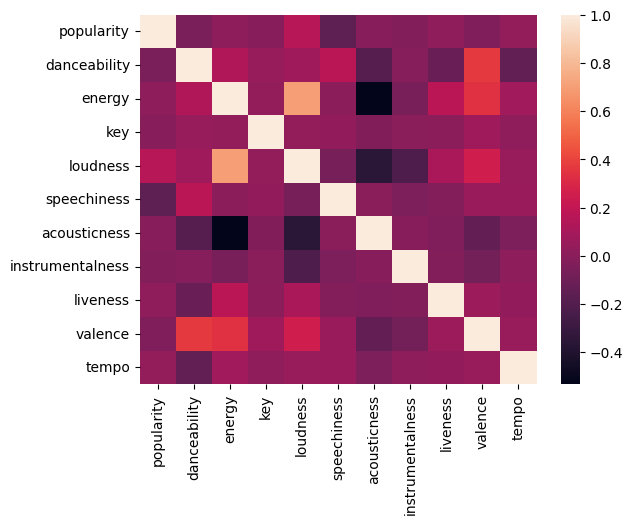

In [188]:
# Creating a heatmap to visualize correlations
ax = sns.heatmap(track_df.corr(), annot=False)

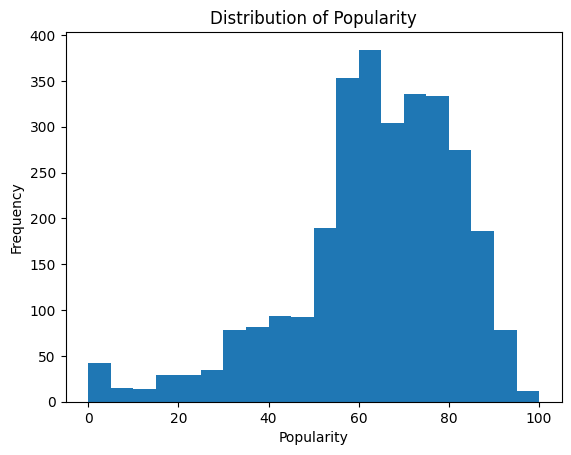

Mean Popularity: 63.281999324552515
Median Popularity: 65.0
75th Percentile Popularity: 77.0


In [189]:
# Distribution of popularity

# Plotting a histogram of the 'popularity' feature
plt.hist(track_df['popularity'], bins=20)
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Distribution of Popularity')
plt.show()

# Calculating summary statistics to find cut-off value
popularity_mean = track_df['popularity'].mean()
popularity_median = track_df['popularity'].median()
popularity_percentile = track_df['popularity'].quantile(0.75)

print("Mean Popularity:", popularity_mean)
print("Median Popularity:", popularity_median)
print("75th Percentile Popularity:", popularity_percentile)

**Dataset overview:**

Mean Popularity: 63.281999324552515

Median Popularity: 65.0

75th Percentile Popularity: 77.0

In [190]:
# Creating is_popular column with our cutoff point - considering 65 as our cutoff value from the median popularity
track_df['is_popular']=(track_df['popularity']>=65).astype('int')
track_df.head()

,track.name,album_name,album_type,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist,is_popular
0,#Sarkanbaltsarkanais,#Sarkanbaltsarkanais,single,38.0,0.738,0.785,11.0,-5.003,0.1040,0.0608,0.00000,0.403,0.6260,110.118,Bermudu Divstūris,0
1,'Til We Meet Again,MY WORLD - The 3rd Mini Album,single,63.0,0.474,0.857,5.0,-2.577,0.0571,0.1340,0.00000,0.113,0.5520,155.710,aespa,0
2,00:00,00:00,single,60.0,0.563,0.572,4.0,-8.769,0.1250,0.6400,0.00227,0.100,0.3920,95.013,Lartiste,0
3,0321,0321,single,67.0,0.658,0.417,2.0,-6.485,0.0366,0.6250,0.00000,0.132,0.0748,171.974,space x,1
4,085 - Ao Vivo,Pode Crê (Ao Vivo),album,83.0,0.850,0.655,2.0,-2.891,0.0298,0.2110,0.00000,0.952,0.7970,106.031,MC Rogerinho,1


In [191]:
# Dropping popularity score column since we will not be using it
track_df.drop(['popularity'], axis=1, inplace=True)
track_df.head()

,track.name,album_name,album_type,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist,is_popular
0,#Sarkanbaltsarkanais,#Sarkanbaltsarkanais,single,0.738,0.785,11.0,-5.003,0.1040,0.0608,0.00000,0.403,0.6260,110.118,Bermudu Divstūris,0
1,'Til We Meet Again,MY WORLD - The 3rd Mini Album,single,0.474,0.857,5.0,-2.577,0.0571,0.1340,0.00000,0.113,0.5520,155.710,aespa,0
2,00:00,00:00,single,0.563,0.572,4.0,-8.769,0.1250,0.6400,0.00227,0.100,0.3920,95.013,Lartiste,0
3,0321,0321,single,0.658,0.417,2.0,-6.485,0.0366,0.6250,0.00000,0.132,0.0748,171.974,space x,1
4,085 - Ao Vivo,Pode Crê (Ao Vivo),album,0.850,0.655,2.0,-2.891,0.0298,0.2110,0.00000,0.952,0.7970,106.031,MC Rogerinho,1


In [192]:
# Seeing the distribution of data points in each category
track_df["is_popular"].value_counts()

1    1525
0    1436
Name: is_popular, dtype: int64

# Logistic Regression Model with the Original Data

In [193]:
# Importing dependencies related to model building
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
import tensorflow as tf

In [194]:
# Splitting the data into features (X) and target (y)
y = track_df[['is_popular']]
X = track_df[['speechiness','acousticness','liveness','valence','energy','loudness']]

In [195]:
# Splitting the data using train_test_split
x_train,x_test,y_train,y_test= train_test_split(X,y)

In [196]:
# Instantiating the Logistic Regression model and assigning a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state=1)

# Fitting the model using training data
lr_model = logistic_regression_model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [197]:
# Making a prediction using the testing data
testing_predictions = lr_model.predict(x_test)

In [198]:
# Printing the accuracy and balanced accuracy score of the model
print(f"Training Data Score: {lr_model.score(x_train, y_train)}")
print(f"Testing Data Score: {lr_model.score(x_test, y_test)}")
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, testing_predictions)}")

Training Data Score: 0.6013513513513513
Testing Data Score: 0.6167341430499326
Balanced Accuracy Score: 0.6137811634349031


In [199]:
# Generating a confusion matrix for the model
testing_matrix = confusion_matrix(y_test, testing_predictions)
print(testing_matrix)

[[180 181]
 [103 277]]


In [200]:
# Printing the classification report for the model
testing_report = classification_report(y_test, testing_predictions)
print(testing_report)

              precision    recall  f1-score   support

           0       0.64      0.50      0.56       361
           1       0.60      0.73      0.66       380

    accuracy                           0.62       741
   macro avg       0.62      0.61      0.61       741
weighted avg       0.62      0.62      0.61       741



For the "0" label (NOT POPULAR), the precision is 0.64, indicating that the model  predicts not popular track with a precision of 64%. For the "1" label (popular), the precision is 0.60, meaning that when the model predicts popular track, it is correct around 60% of the time.

For the "0" label (Not popular), the recall is 0.50, . For the "1" label (POPULAR), the recall is 0.73, meaning that the model captures approximately 73% of the actual popular track.

Overall, the logistic regression model demonstrates  predictive performance for both the "0" and "1" labels.

# Predict a Logistic Regression Model with Resampled Training Data

In [201]:
# Importing the RandomOverSampler module form imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# Instantiating the random oversampler model and assigning a random_state parameter of 1 to the model
ROS = RandomOverSampler(random_state=1)

# Fitting the original training data to the random_oversampler model
x_resampled, y_resampled= ROS.fit_resample(x_train, y_train)

In [202]:
# Counting the distinct values of the resampled labels data
y_resampled.value_counts()

is_popular
0             1145
1             1145
dtype: int64

In [203]:
# Instantiating the Logistic Regression model and assigning a random_state parameter of 1 to the model
from sklearn.linear_model import LogisticRegression
ros_model = LogisticRegression(solver='lbfgs', random_state=1)


# Fitting the model using the resampled training data
ros_model.fit(x_resampled, y_resampled)


# Making a prediction using the testing data
y_prediction = ros_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [204]:
# Printing the accuracy and balanced accuracy score of the model
print(f"Training Data Score: {ros_model.score(x_train, y_train)}")
print(f"Testing Data Score: {ros_model.score(x_test, y_test)}")
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_prediction)}")

Training Data Score: 0.5981981981981982
Testing Data Score: 0.6194331983805668
Balanced Accuracy Score: 0.6174515235457063


In [205]:
# Generating a confusion matrix for the model
ros_testing_matrix = confusion_matrix(y_test, y_prediction)
print(ros_testing_matrix)

[[195 166]
 [116 264]]


In [206]:
# Printing the classification report for the model
ros_testing_report = classification_report(y_test, y_prediction)
print(ros_testing_report)

              precision    recall  f1-score   support

           0       0.63      0.54      0.58       361
           1       0.61      0.69      0.65       380

    accuracy                           0.62       741
   macro avg       0.62      0.62      0.62       741
weighted avg       0.62      0.62      0.62       741



For the "0" label (NOT POPULAR), the precision is 0.64, indicating that the model  predicts not popular track with a precision of 64%. For the "1" label (popular), the precision is 0.60, meaning that when the model predicts popular track, it is correct around 60% of the time.

For the "0" label (Not popular), the recall is 0.50, . For the "1" label (POPULAR), the recall is 0.73, meaning that the model captures approximately 73% of the actual popular track.

Overall, the logistic regression model demonstrates  predictive performance for both the "0" and "1" labels.

**Conclusion from the 2 logistic regression models**

Comparing the two models, it appears that there is not a big difference between the accuracy of the logistic regression model with resampled data and the model with the original data. Model with the resampled data achieved a slightly higher recall and F1-score for class 0 but lower recall and F1-score for class 1 as well as 1% lower . Resampling the data helped to balance the class distribution and improve the model's performance in identifying both classes more accurately.

# Neural Network

Is_popular is our target variables and speechiness, acousticness, liveness, valence, energy and loudness are the feature variables. For the target variable, 1 is considered as Popular and 0 is considered as non-Popular.

In [207]:
# Splitting the data into features (X) and target (y)
y = track_df[['is_popular']]
X = track_df[['speechiness','acousticness','liveness','valence','energy','loudness']]

In [208]:
# Splitting the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [209]:
# Creating a StandardScaler instances
scaler = StandardScaler()

# Fitting the StandardScaler
X_scaler = scaler.fit(X_train)

# Scaling the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [210]:
# Defining the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 10
hidden_nodes_layer2 = 20

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Checking the structure of the model
nn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 10)                70        
                                                                 
 dense_39 (Dense)            (None, 20)                220       
                                                                 
 dense_40 (Dense)            (None, 1)                 21        
                                                                 
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________


In [211]:
# Compiling the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [212]:
# Training the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
70/70 [==============================] - 1s 2ms/step - loss: 0.6816 - accuracy: 0.5590
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6692 - accuracy: 0.5869
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6639 - accuracy: 0.5968
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6607 - accuracy: 0.5977
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6580 - accuracy: 0.6014
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6573 - accuracy: 0.6072
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6558 - accuracy: 0.6086
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6552 - accuracy: 0.6099
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6537 - accuracy: 0.6113
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.6158
Epoch 11/

In [213]:
# Evaluating the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

24/24 - 0s - loss: 0.6809 - accuracy: 0.5803 - 157ms/epoch - 7ms/step
Loss: 0.6809135675430298, Accuracy: 0.5802968740463257


<Axes: >

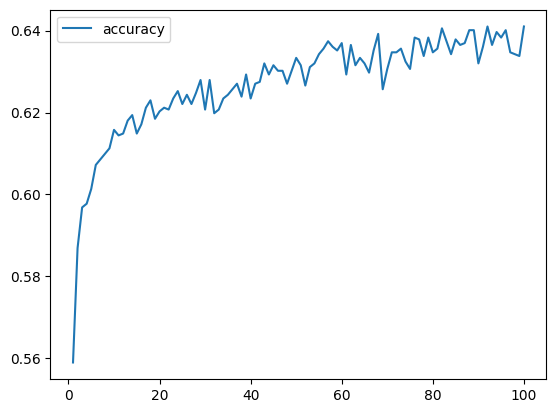

In [214]:
# Plotting the accuracy
history_df = pd.DataFrame(fit_model.history, index = range(1, len(fit_model.history['loss'])+1))
history_df.plot(y = 'accuracy')

Cutoff = 65

Layer1 = 10 : activation function = relu

Layer2 = 20 : activation function = relu

Loss: 0.6809 - Accuracy: 0.5803

A loss value of 68% indicates that the model can be further optimized. The accuracy percent shows that 58% of the model's predicted values align with the true values in the original dataset.

# Changing activation function

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 10
hidden_nodes_layer2 = 20


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Checking the structure of the model
nn.summary()

In [229]:
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

In [231]:
# Evaluating the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

24/24 - 0s - loss: 0.6628 - accuracy: 0.6059 - 155ms/epoch - 6ms/step
Loss: 0.6628409028053284, Accuracy: 0.6059378981590271


Cutoff = 65

Layer1 = 10 : activation function = relu

Layer2 = 20 : activation function = tanh

Loss: 0.6628409028053284, Accuracy: 0.6059378981590271


By changing the activation function, the model was able to take into account the negative values in the dataset as the tanh function takes input and outputs values in the range -1 to 1 and hence might have fit the data better. This change resulted in a slightly lower loss (66%) and higher accuracy (61%). This added complexity improved the model's performance by almost 3%.

# Adding hidden layer with the original activation function

Next, we add a hidden layer to our model in order to enable more interaction between features and yield a higher accuracy. We kept the activation function as the original one (relu).

In [ ]:
# Defining the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 10
hidden_nodes_layer2 = 20
hidden_nodes_layer3 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

In [216]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

In [218]:
#Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

24/24 - 0s - loss: 0.6953 - accuracy: 0.6005 - 163ms/epoch - 7ms/step
Loss: 0.6952848434448242, Accuracy: 0.6005398035049438


Cutoff = 65

Layer1 = 10 : activation function = relu

Layer2 = 20 : activation function = relu

Layer3 = 30 : activation function = relu

Loss: 0.6952848434448242, Accuracy: 0.6005398035049438


By adding a hidden layer, the model's complexity increased, allowing for the extraction of more intricate patterns in the data. This change resulted in a slightly higher loss (69%) and accuracy (60%). This added complexity improved the model's performance by 2%.

# Changing activation function and adding hidden layer

By changing the activation function, the model might become more effective in capturing non-linear as well as non-positive patterns in the data. Hence we introduced the tanh activation function for the second and third hidden layers for this particular attempt.

In [219]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 10
hidden_nodes_layer2 = 20
hidden_nodes_layer3 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Checking the structure of the model
nn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 10)                70        
                                                                 
 dense_46 (Dense)            (None, 20)                220       
                                                                 
 dense_47 (Dense)            (None, 30)                630       
                                                                 
 dense_48 (Dense)            (None, 1)                 31        
                                                                 
Total params: 951
Trainable params: 951
Non-trainable params: 0
_________________________________________________________________


In [220]:
# Compiling the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Training the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

In [222]:
# Evaluating the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

24/24 - 0s - loss: 0.6714 - accuracy: 0.5789 - 156ms/epoch - 6ms/step
Loss: 0.6714479327201843, Accuracy: 0.5789473652839661


Cutoff = 65

Layer1 = 10 : activation function = relu

Layer2 = 20 : activation function = tanh

Layer3 = 30 : activation function = tanh

Loss: 0.6714479327201843, Accuracy: 0.5789473652839661

By adding a hidden layer and changin the activation functions the model's complexity increased however, this change impaired the accuracy of the model as it was back to 58% and slightly decreased the loss to 67% from the previous model.

Hence it seems like the best accuracy of the model was obtained with 2 hidden layers with relu as the activation function of the first layer and tanh as the activation function for the second layer.

In [105]:
# Exporting our model to HDF5 file
nn.save('Model/Model.h5')

# Random Forest

Using Random Forest model which is robust against overfitting, outliers and non-linear data

In [232]:
from sklearn.ensemble import RandomForestClassifier

# Using the speechiness, acousticness, liveness, valence, energy and loudness columns
X = track_df[['speechiness','acousticness','liveness','valence','energy','loudness']]

# Updating y with the target variable column
y = track_df['is_popular'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

# Printing the accuracies of the three models
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.5767284991568297


In [233]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57       304
           1       0.56      0.61      0.58       289

    accuracy                           0.58       593
   macro avg       0.58      0.58      0.58       593
weighted avg       0.58      0.58      0.58       593



In [234]:
y_pred = rf_model.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1132
           1       1.00      1.00      1.00      1236

    accuracy                           1.00      2368
   macro avg       1.00      1.00      1.00      2368
weighted avg       1.00      1.00      1.00      2368



In [235]:
# Using the speechiness,acousticness,liveness,valence,energy and loudness columns
X = track_df[['speechiness','acousticness','liveness','valence','energy','loudness']]

# Updating y with the target variable column
y = track_df['is_popular'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Random Forest model
rf_model2 = RandomForestClassifier(criterion='entropy', max_depth=None,
                                      min_samples_leaf=2, class_weight='balanced',
                                      random_state=42)
rf_model2.fit(X_train, y_train)
rf_predictions = rf_model2.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

# Printing the accuracies of the three models
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.5902192242833052


In [236]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.61      0.55      0.58       304
           1       0.57      0.63      0.60       289

    accuracy                           0.59       593
   macro avg       0.59      0.59      0.59       593
weighted avg       0.59      0.59      0.59       593



In [237]:
# Sorting the features by their importance
importances = rf_model2.feature_importances_
sorted(zip(rf_model2.feature_importances_, X.columns), reverse=True)

[(0.19127473084035562, 'loudness'),
 (0.17676254467248068, 'speechiness'),
 (0.1653504599445122, 'acousticness'),
 (0.16188629026472018, 'energy'),
 (0.15346200395471699, 'valence'),
 (0.15126397032321445, 'liveness')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

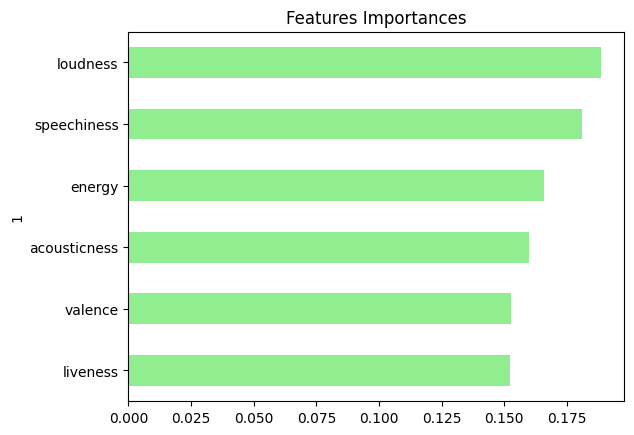

In [238]:
# Creating a bar graph to visualize feature importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

The random forest model performs with an accuracy of 58%.

Conclusion: - The logistic regression model with resampled data showed improved performance compared to the model with original data, with slightly higher precision, recall, and F1-score for both classes. - The neural network model showed varying performance based on changes made, indicating the importance of model architecture and activation functions. -  The random forest model achieved an accuracy of 0.5565, indicating moderate performance. - Overall, further model optimization and exploration of different algorithms may be necessary to improve the predictive performance of the models on the given dataset.

Overall, the optimization process involved experimenting with different architectural changes and activation functions. The addition of a hidden layer did not yield a significant improvement but changing the activation function resulted in a better-performing model with a lower loss and higher accuracy.